In [27]:
!pip install mlxtend
!pip install scikit-learn
!pip install xgboost

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import matplotlib.gridspec as gridspec
import itertools
import xgboost as xgb
import warnings


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
full_data = pd.read_csv("weatherAUS.csv")

In [29]:
full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

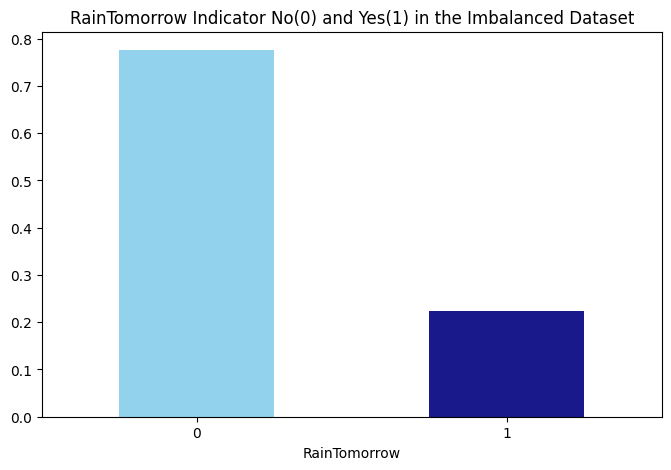

In [30]:
fig = plt.figure(figsize = (8,5))
full_data.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

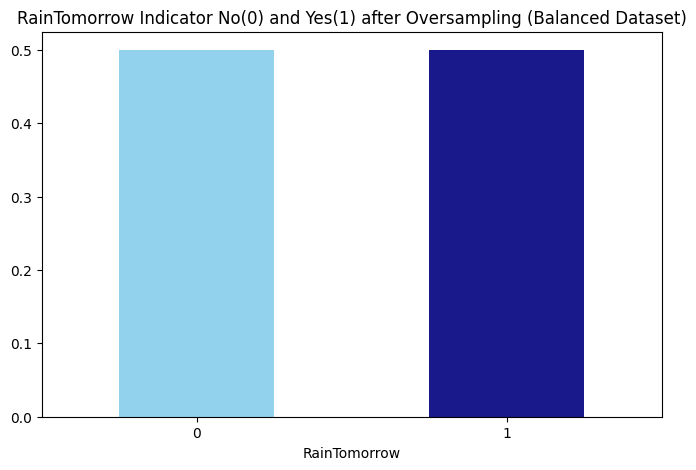

In [31]:
from sklearn.utils import resample

# Assuming full_data is already defined
no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]

# Oversample the minority class
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)

# Combine the oversampled minority class with the majority class
oversampled = pd.concat([no, yes_oversampled])

# Plot the balanced dataset
fig = plt.figure(figsize=(8, 5))
oversampled.RainTomorrow.value_counts(normalize=True).plot(kind='bar', color=['skyblue', 'navy'], alpha=0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()


<Axes: >

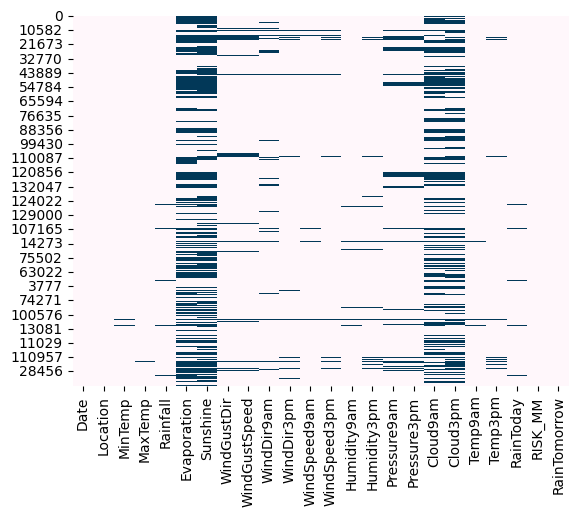

In [32]:
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

In [33]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

Total   Percent
Sunshine     104831  0.475140
Evaporation   95411  0.432444
Cloud3pm      85614  0.388040
Cloud9am      81339  0.368664

In [34]:
oversampled.select_dtypes(include=['object']).columns


Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [35]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])


In [36]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])


In [37]:
warnings.filterwarnings("ignore")

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

# Use a simpler estimator and reduce the number of iterations
mice_imputer = IterativeImputer(estimator=LinearRegression(), max_iter=5, random_state=0)

# Perform imputation
MiceImputed = oversampled.copy(deep=True)
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [38]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.118151
Sunshine            5.877605
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.600000
Pressure3pm         8.600000
Cloud9am            4.000000
Cloud3pm            3.628532
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RISK_MM             5.200000
RainTomorrow        1.000000
dtype: float64


In [39]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(156473, 24)

<Axes: >

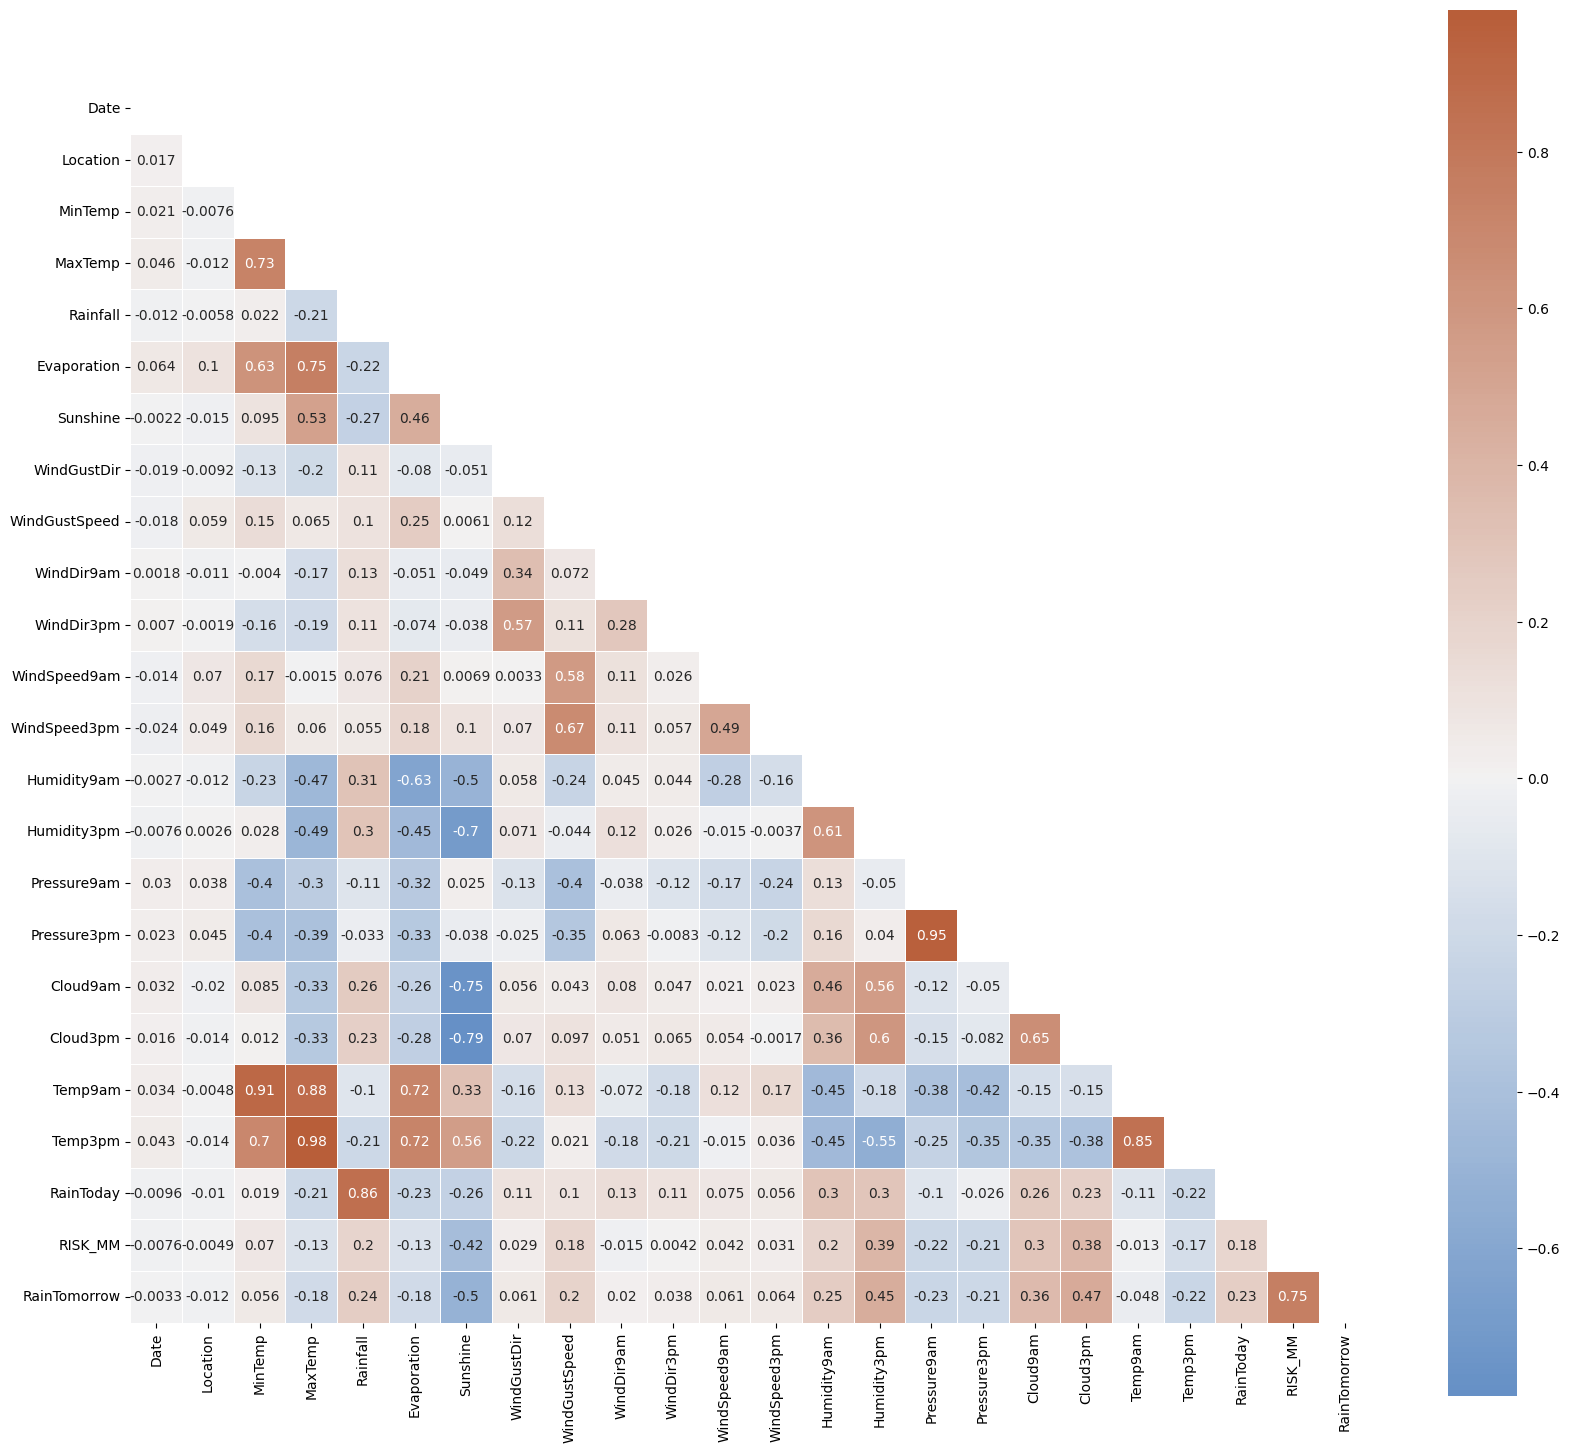

In [40]:
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

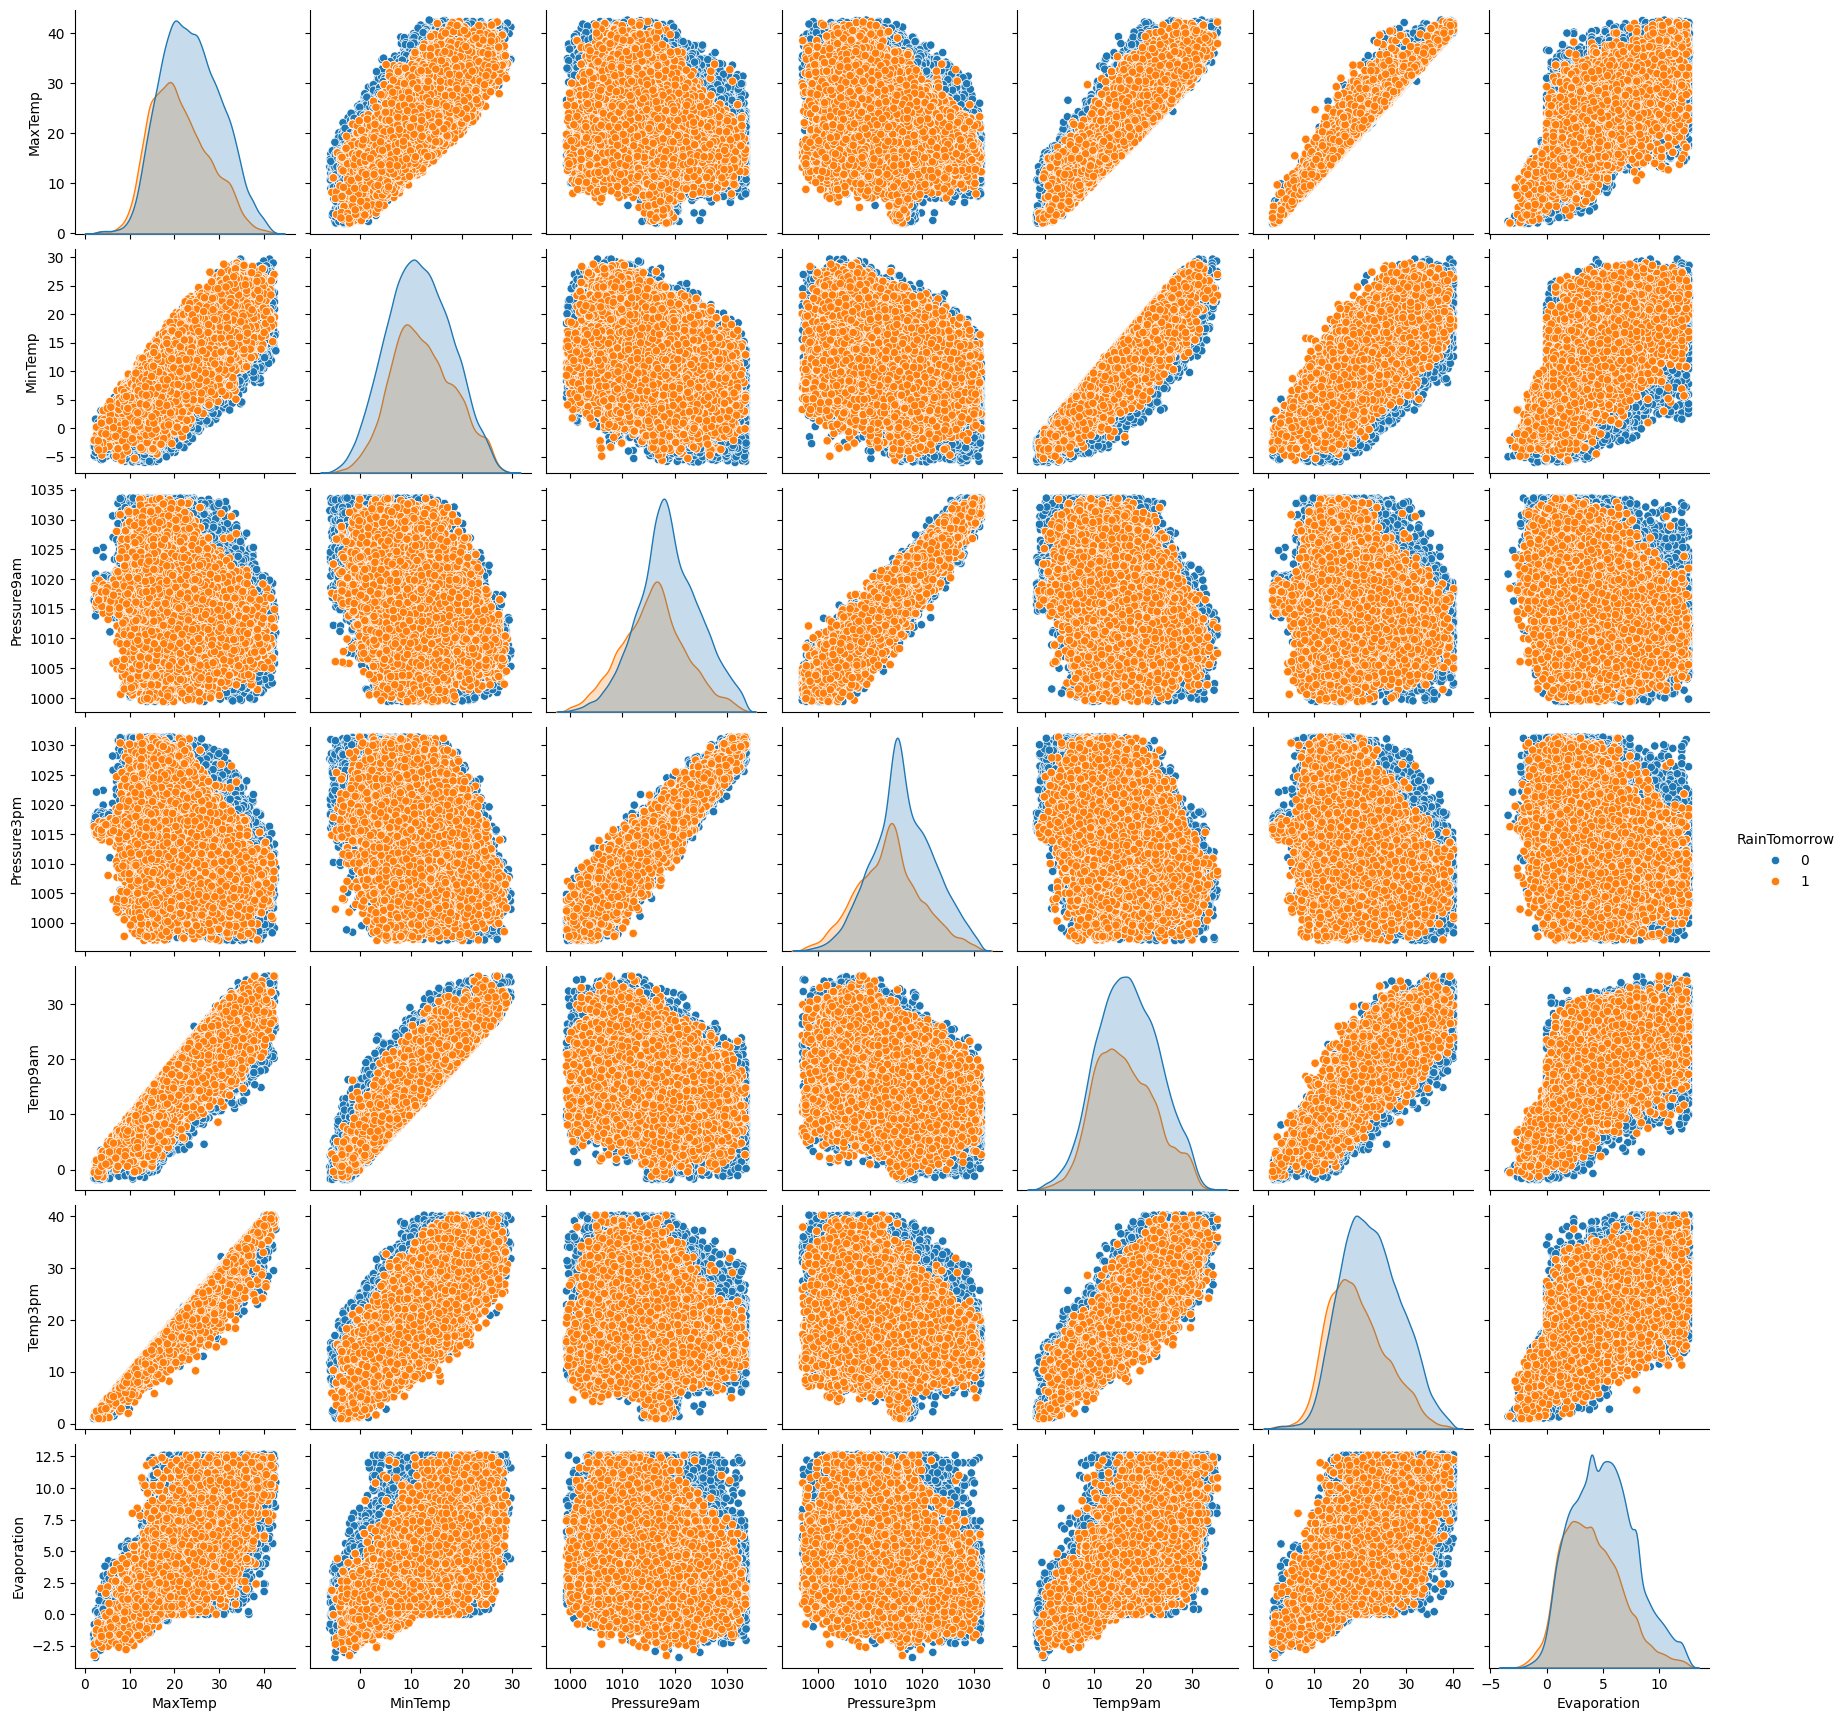

In [41]:
sns.pairplot( data=MiceImputed, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow' )

In [42]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)


In [43]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Sunshine', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
       'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'RISK_MM'],
      dtype='object')


In [44]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'Cloud3pm', 'RISK_MM']
[0.00233608 0.00257386 0.00291934 0.00401399 0.01072205 0.00267512
 0.06196831 0.00163828 0.00794172 0.0019329  0.00193109 0.00155852
 0.00216162 0.00731007 0.03460588 0.00817436 0.01313512 0.01957172
 0.05306162 0.00311747 0.0057028  0.00398492 0.74696315]


In [45]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [46]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [47]:
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay

def plot_roc_curve(fper, tper, roc_auc):
    plt.figure()
    plt.plot(fper, tper, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0 = time.time()
    
    if not verbose:
        model.fit(X_train, y_train, verbose=0)
    else:
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time() - t0
    
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test, y_pred, digits=5))
    
    # Plot ROC curve
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    fper, tper, thresholds = roc_curve(y_test, probs)
    plot_roc_curve(fper, tper, roc_auc)
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues, values_format='.2f')
    plt.show()
    
    return model, accuracy, roc_auc, coh_kap, time_taken


Accuracy = 0.7894884838569494
ROC Area under Curve = 0.8634526456950228
Cohen's Kappa = 0.5494664941903562
Time taken = 3.2276577949523926
              precision    recall  f1-score   support

           0    0.80709   0.86020   0.83280     23842
           1    0.75686   0.67913   0.71589     15277

    accuracy                        0.78949     39119
   macro avg    0.78197   0.76967   0.77434     39119
weighted avg    0.78747   0.78949   0.78714     39119



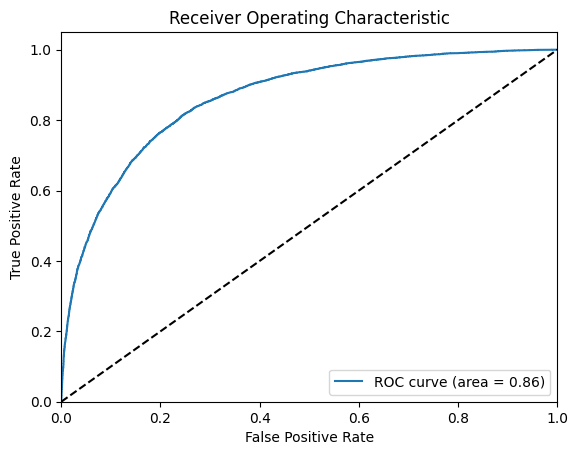

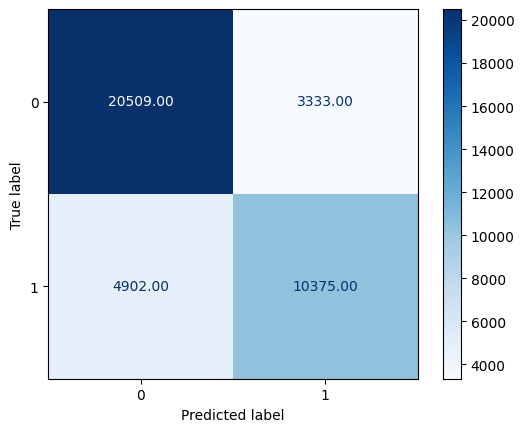

Accuracy = 0.8608860144686725
ROC Area under Curve = 0.8981920999221615
Cohen's Kappa = 0.7106207892442413
Time taken = 0.8055009841918945
              precision    recall  f1-score   support

           0    0.89997   0.86826   0.88383     23842
           1    0.80511   0.84938   0.82665     15277

    accuracy                        0.86089     39119
   macro avg    0.85254   0.85882   0.85524     39119
weighted avg    0.86292   0.86089   0.86150     39119



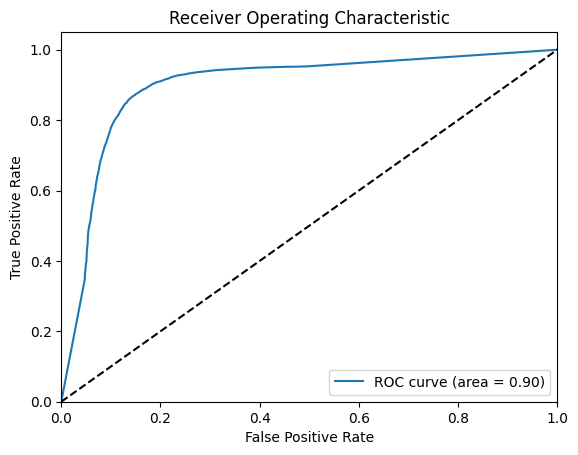

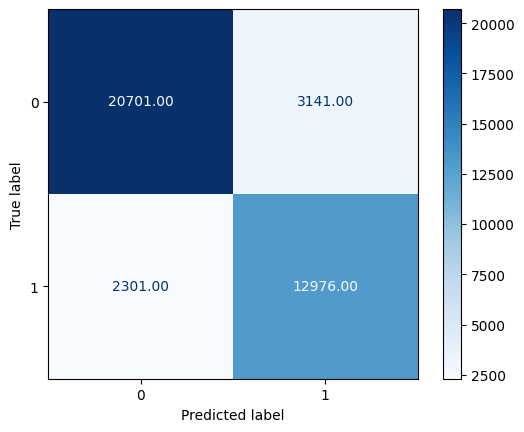

Accuracy = 0.9304174442086965
ROC Area under Curve = 0.9798295730763188
Cohen's Kappa = 0.8544812711681488
Time taken = 59.72485566139221
              precision    recall  f1-score   support

           0    0.95013   0.93490   0.94245     23842
           1    0.90089   0.92341   0.91201     15277

    accuracy                        0.93042     39119
   macro avg    0.92551   0.92916   0.92723     39119
weighted avg    0.93090   0.93042   0.93057     39119



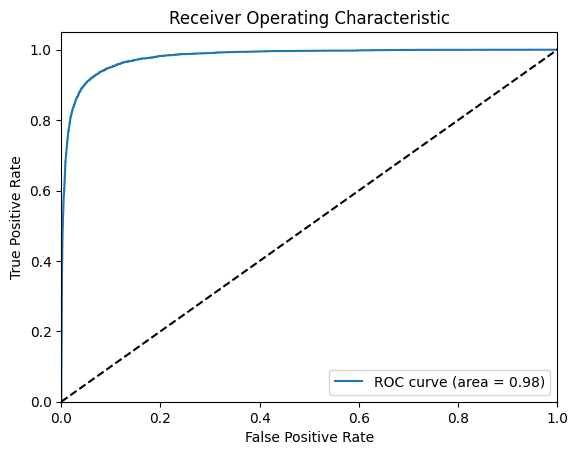

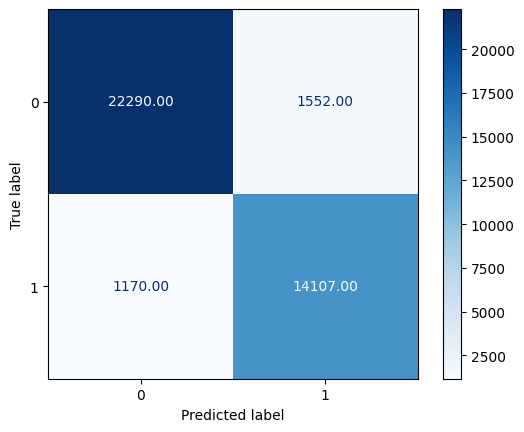

Accuracy = 0.9495385873872032
ROC Area under Curve = 0.9899590245545125
Cohen's Kappa = 0.8956808033658658
Time taken = 28.811107397079468
              precision    recall  f1-score   support

           0    0.98665   0.92979   0.95737     23842
           1    0.89947   0.98036   0.93817     15277

    accuracy                        0.94954     39119
   macro avg    0.94306   0.95508   0.94777     39119
weighted avg    0.95260   0.94954   0.94988     39119



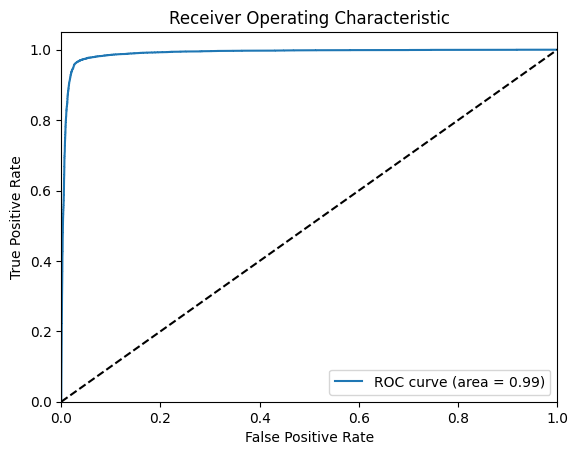

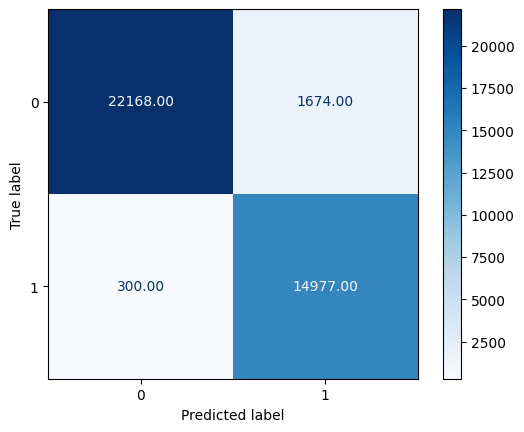

In [48]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)



# Random Forest
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)



params_xgb = {'n_estimators': 500,
              'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)


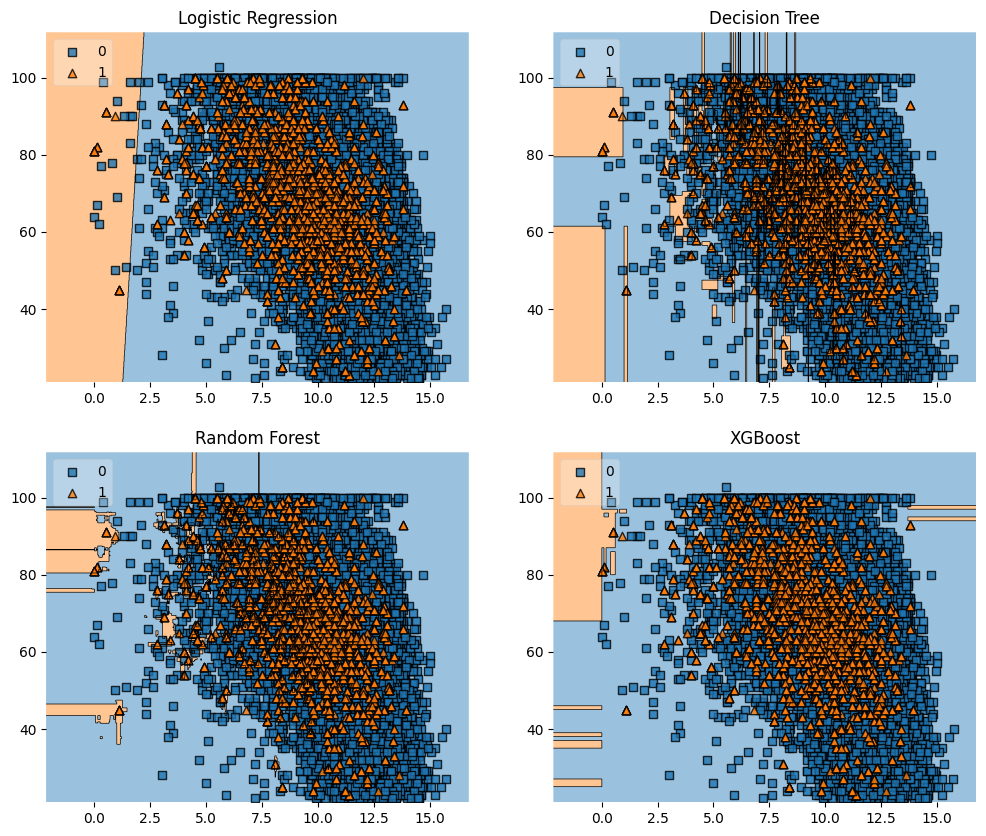

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from mlxtend.plotting import plot_decision_regions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools

value = 1.80
width = 0.90

# Define classifiers
clf1 = LogisticRegression(random_state=12345)
clf2 = DecisionTreeClassifier(random_state=12345) 
clf4 = RandomForestClassifier(random_state=12345)
clf7 = xgb.XGBClassifier(random_state=12345)

# Preparing the dataset
X_list = MiceImputed[["Sunshine", "Humidity9am", "Cloud3pm"]]  # Important features
X = np.asarray(X_list, dtype=np.float32)
y_list = MiceImputed["RainTomorrow"]
y = np.asarray(y_list, dtype=np.int32)

# Plotting Decision Regions
gs = gridspec.GridSpec(2, 2)  # Adjusted for the number of classifiers
fig = plt.figure(figsize=(12, 10))

labels = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']

for clf, lab, grd in zip([clf1, clf2, clf4, clf7],
                         labels,
                         itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, 
                                filler_feature_values={2: value}, 
                                filler_feature_ranges={2: width}, 
                                legend=2)
    plt.title(lab)

plt.show()


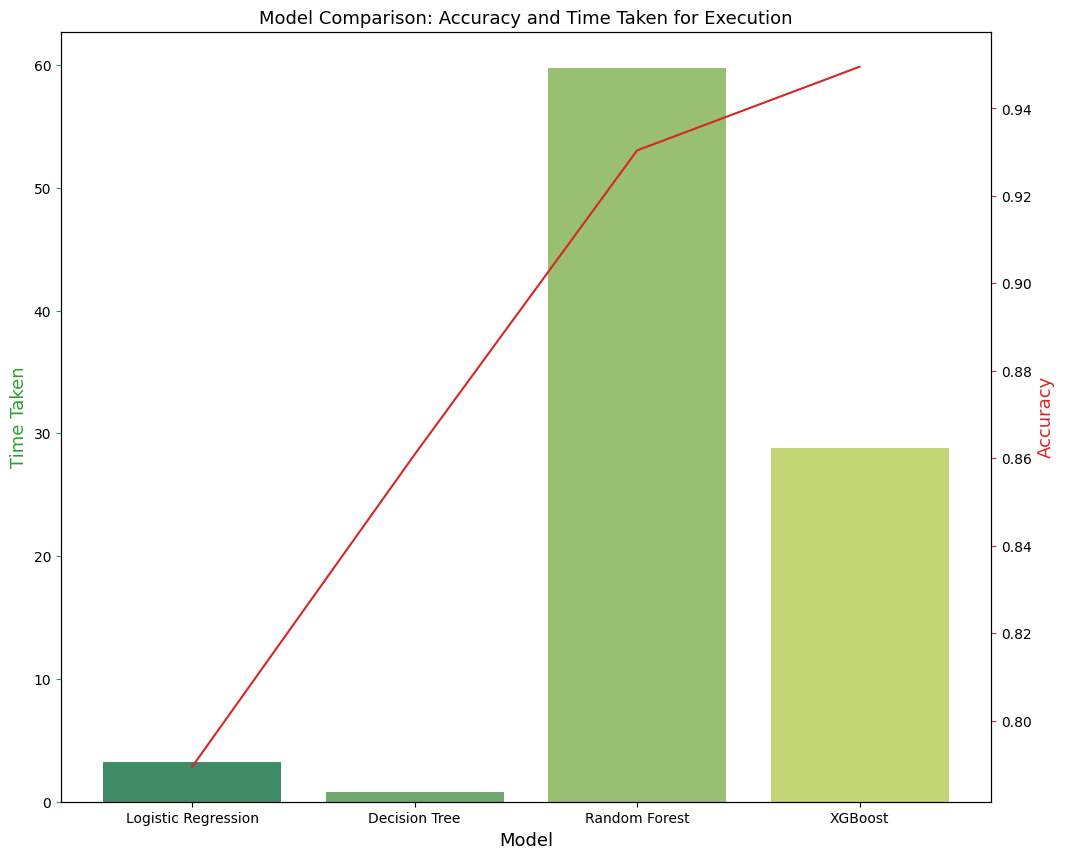

In [51]:
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_rf, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_rf, roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_rf, coh_kap_xgb]
tt = [tt_lr, tt_dt, tt_rf, tt_xgb]

model_data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': accuracy_scores,
    'ROC_AUC': roc_auc_scores,
    'Cohen_Kappa': coh_kap_scores,
    'Time taken': tt
}

data = pd.DataFrame(model_data)

# Plotting Model Comparison
fig, ax1 = plt.subplots(figsize=(12, 10))
ax1.set_title('Model Comparison: Accuracy and Time Taken for Execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time Taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data=data, palette='summer', ax=ax1)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data=data, sort=False, color=color, ax=ax2)
ax2.tick_params(axis='y', color=color)

plt.show()

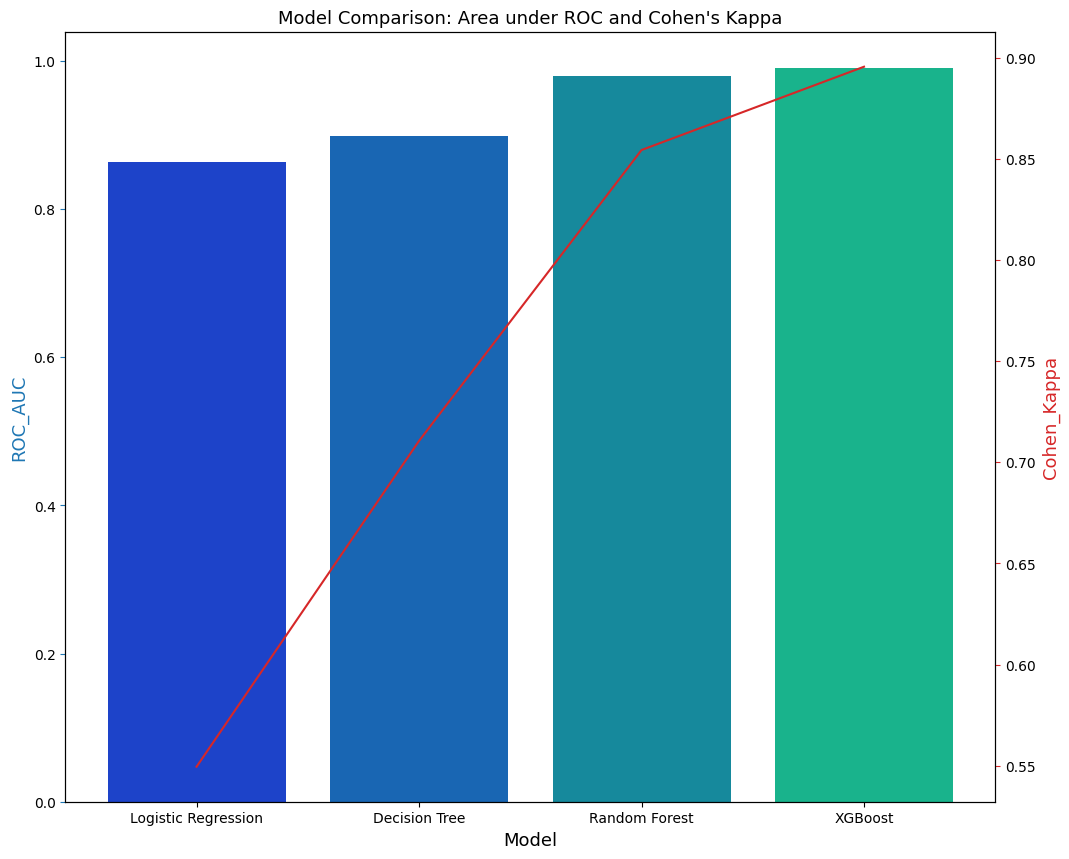

In [52]:
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_rf, roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_rf, coh_kap_xgb]

model_data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'ROC_AUC': roc_auc_scores,
    'Cohen_Kappa': coh_kap_scores
}

data = pd.DataFrame(model_data)

# Plotting Model Comparison for ROC AUC and Cohen's Kappa
fig, ax3 = plt.subplots(figsize=(12, 10))
ax3.set_title('Model Comparison: Area under ROC and Cohen\'s Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data=data, palette='winter', ax=ax3)
ax3.tick_params(axis='y', color=color)

ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data=data, sort=False, color=color, ax=ax4)
ax4.tick_params(axis='y', color=color)

plt.show()